# Homework 7: Gene expression, by experiment

#### **Please read the following instructions carefully before you continue.**

This template notebook is for Homework 7, due Thursday, May 30th, 2024.

To use this template, click `File` > `Save a copy in Drive`. You now have your own editable copy to which you can add your code. However, before you make changes, note that we've scaffolded this notebook to help get you started:

- We've already written `import` statements for all the modules you should need. This week, you could feasibly do everything without importing any external modules; do whatever is most helpful for you.
- We provide an introduction that lays out one potential approach for solving the problem, explaining what each logical "chunk" of your code ought to accomplish. You can use this as a starting point for writing your own code.  

Of course, if you'd rather do your own thing, you are not required to follow the path we've laid out, or use the modules we've recommended. However, a few things _are_ required (refer to the [Intro to Colab](https://colab.research.google.com/drive/1fq_HaiuYb1L18uGcoA3eGs6taiUafR-6?usp=sharing) notebook):

- _Literate style._ Dumping everything into a single, monstrous code cell is illegible and unacceptable. Remember to divide your code into reasonable, logical chunks, and to follow up each code cell with a text cell that explains and interprets the results.
- _Comments._ That said, writing "literate" code is not an excuse to avoid writing comments :)
- _Problem labels/numbers._ Please use text cells to clearly label where your solution to one problem ends, and the next begins.

Remember that a human is going to read and grade your notebook, so it is in your best interest to help them understand your work clearly. Your finished solution to a given problem should flow coherently from one code cell to the next. (Our "scaffold" helps you do this!)

If you get stuck, remember that [tutorials](https://bi1.caltech.edu/2024/tutorials) are held in-person each week. Also, note that in accordance with course policy, [the use of generative AI tools is forbidden](https://bi1.caltech.edu/2024/policies) unless otherwise specified.

---

## Introduction

This special "computational project" set serves as the culmination of all your hard work programming this quarter!

You'll draw from the file handling and plotting you learned for HW 3 and 4, develop some new image segmentation skills, and compare your results with the theoretical predictions you made in HW 6!

Most excitingly, you'll use it all to study a real-world dataset, and recapitulate the analysis done in a real-world paper published just a few years ago. In other words, you are going to get your best taste yet of _real_ biological research.

This time, most of the information to get you started isn't included in this template file; instead, it's in the problem set text itself, as well as in the tutorial recordings and notebooks. As always, reach out if you have any questions!

In [ ]:
## relevant imports
# numerical computing
import numpy as np

# plotting
import matplotlib.pyplot as plt

# working with filenames
import glob

# image processing
import skimage.io
import skimage.exposure
import skimage.measure

# csv work
import pandas as pd

# least-squares regression
import scipy.optimize

# access files from your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## tutorial 2024/05/20

##Question 1a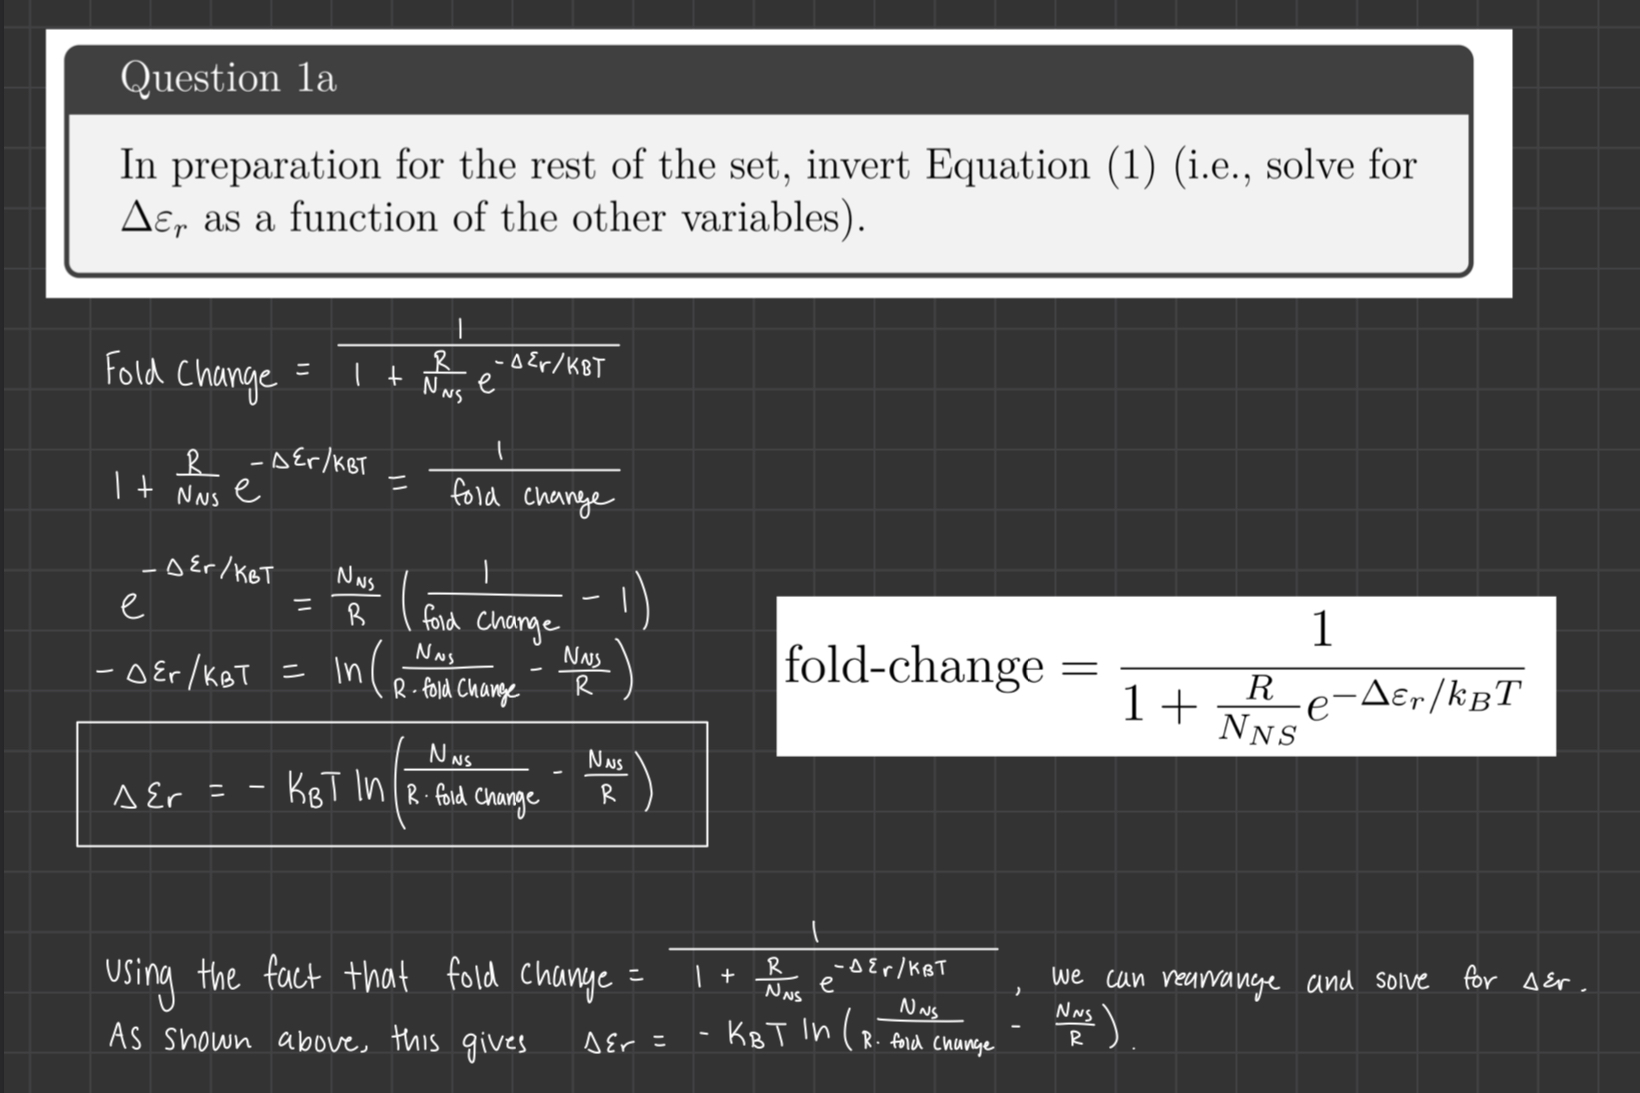

##Question 1b

In [ ]:
# Based on question 1a, this is a method that calculates the binding energy that
# takes in the parameters: number of repressors and value of the foldchange.
# Returns the binding energy with units of KbT

def binding_energy(repressor, foldchange):
  return -1*np.log(((4.6 * pow(10,6))/(repressor * foldchange)) - ((4.6 * pow(10,6))/repressor))

In [ ]:
# Calculate the binding energy for each operator using the repressor # and
# measured fold change as described in table 1

operator1 = binding_energy(260, (2.77 * pow(10, -3)))
operator2 = binding_energy(260, (1.24 * pow(10, -2)))
operator3 = binding_energy(260, (4.77 * pow(10, -1)))

print(operator1)
print(operator2)
print(operator3)

-15.667019345677291
-14.158466515303829
-9.872950203620377


In [ ]:
# These are methods that calculate the theoretical fold change with the number
# of repressors as the only parameter. Each expression uses the previously
# calculated binding energies for each operator.

def foldchange1(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 15.667)))

def foldchange2(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 14.158)))

def foldchange3(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 9.873)))

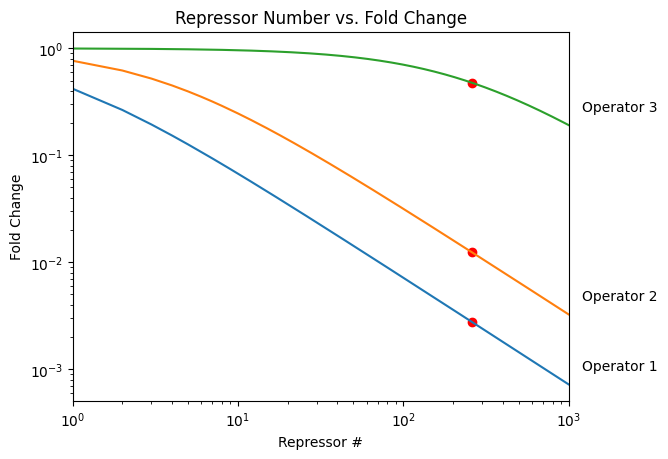

In [ ]:
r = []
fc1 = []
fc2 = []
fc3 = []

# A loop up to 1000 to calculate the fold changes as a function of repressor number.
# The loop calculates the fold changes for each operator.

for i in range(1000):
  r.append(i)
  fc1.append(foldchange1(i))
  fc2.append(foldchange2(i))
  fc3.append(foldchange3(i))

# plots each of the calculated fold chain functions for each operator
plt.plot(r, fc1)
plt.plot(r, fc2)
plt.plot(r, fc3)
plt.xlabel("Repressor #")
plt.ylabel("Fold Change")
plt.title("Repressor Number vs. Fold Change")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 1000)

# Labels for each line
plt.annotate('Operator 1', xy=(r[-1], fc1[-1]), xytext=(10, 10), textcoords='offset points')
plt.annotate('Operator 2', xy=(r[-1], fc2[-1]), xytext=(10, 10), textcoords='offset points')
plt.annotate('Operator 3', xy=(r[-1], fc3[-1]), xytext=(10, 10), textcoords='offset points')

# Plot the points as outlined in Table 1 to compare to the theoretical curves
plt.scatter(260, 0.00277, color='red')
plt.scatter(260, 0.0124, color='red')
plt.scatter(260, 0.477, color='red')

##Question 1c

In [ ]:
# this code was from the tutorial to create a segmentation mask for some inputted
# phase contrast image
def segment_im(im_phase, ip_dist=0.160, area_bounds=(1,4), phase_thresh=0.3, show_mask=False):
  im_normed = (im_phase - im_phase.min()) / (im_phase.max() - im_phase.min())
  im_thresh = im_normed < phase_thresh

  im_lab, num_obj = skimage.measure.label(im_thresh, return_num=True)

  approved_cells = np.zeros_like(im_thresh)
  for i in range(num_obj):
      cell = (im_lab == i + 1)
      cell_area_px = np.sum(cell)
      cell_area = cell_area_px * ip_dist**2
      if (cell_area > area_bounds[0]) and (cell_area < area_bounds[1]):
            approved_cells += cell

  if show_mask:
      im_copy = np.copy(im_normed)
      im_copy[approved_cells] = 1.0
      im_rgb = np.dstack((im_normed, im_copy, im_copy))

      fig, ax = plt.subplots()
      ax.imshow(im_rgb)
      plt.show()

  return approved_cells

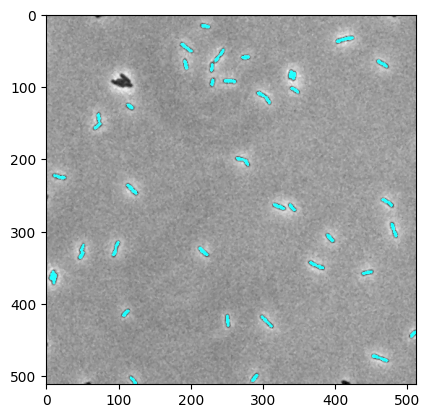

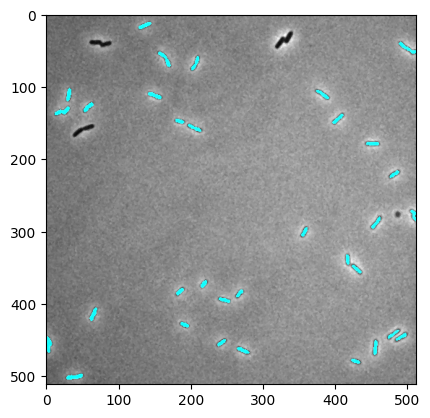

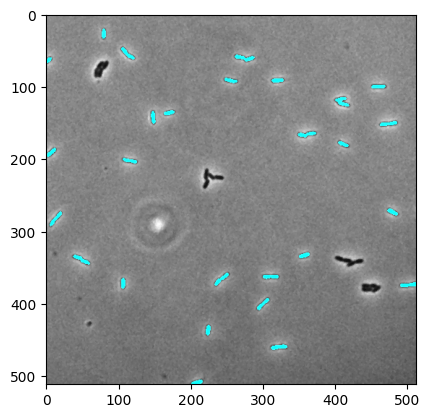

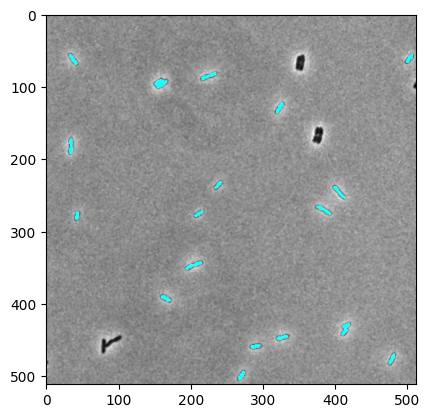

In [ ]:
# Store the file paths for 4 sample lacl titration images
img_phases = []
img_phases.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O1_delta_phase_pos_01.tif")
img_phases.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O2_delta_phase_pos_01.tif")
img_phases.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O3_auto_phase_pos_01.tif")
img_phases.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O1_R60_phase_pos_01.tif")

segmented = []
for i in range(4):
  # processes the paths into a phase contrasted image to be passed into the method
  # that creates a segmentation mask
  segmented.append(segment_im(skimage.io.imread(img_phases[i]), show_mask = True))


##Question 1d

In [ ]:
# this code was from the tutorial. This method takes a phase contrast image and
# the associated fluorescent image to process and compute the fluorescent
# intensities for the segmented cells
def extract_intensities(im_phase, im_fluor):
  im_mask = segment_im(im_phase)
  im_lab, num_cells = skimage.measure.label(im_mask, return_num=True)
  intensity_list = np.zeros(num_cells)

  for i in range(num_cells):
    cell = (im_lab == i + 1)
    tot_intensity = np.sum(cell * im_fluor)
    intensity_list[i] = tot_intensity

  return intensity_list

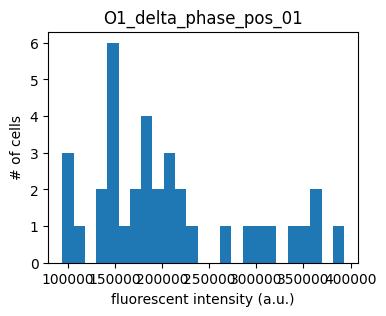

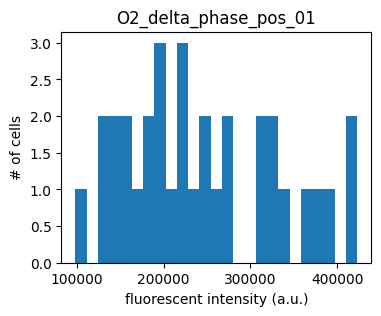

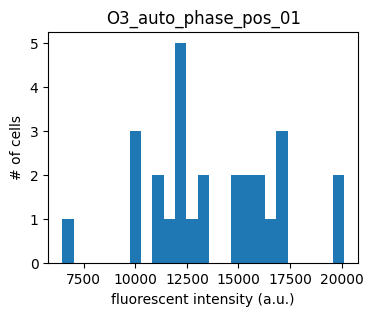

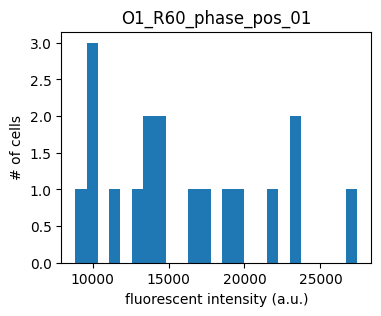

In [ ]:
# Array of titles for the histograms
titles = ["O1_delta_phase_pos_01", "O2_delta_phase_pos_01", "O3_auto_phase_pos_01", "O1_R60_phase_pos_01"]

# paths for all the fluorescent images
fluor_paths = []
fluor_paths.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O1_delta_yfp_pos_01.tif")
fluor_paths.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O2_delta_yfp_pos_01.tif")
fluor_paths.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O3_auto_yfp_pos_01.tif")
fluor_paths.append("/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/O1_R60_yfp_pos_01.tif")

img_fluor = []
for i in range(4):
  # processes the paths to add the fluorescent images into an array
  img_fluor.append(skimage.io.imread(fluor_paths[i]))

for i in range(4):
  # generates the fluorescent intensities for each of the images
  intensity = extract_intensities(skimage.io.imread(img_phases[i]), img_fluor[i])
  # plots a histogram
  fig, ax = plt.subplots(figsize=(4,3))
  ax.set_xlabel('fluorescent intensity (a.u.)')
  ax.set_ylabel('# of cells')
  ax.set_title(titles[i])

  ax.hist(intensity, bins=25);

## Question 1e

In [ ]:
# This method takes in some operator and repressor name to parse all the phases
# that have the same operator and repressor. The method then computes the
# fluorescent intensities for each cell and returns an array with the values
def strain_totals(op, rep):
  # common path to cut down bulkiness in the code
  path = "/content/drive/MyDrive/Colab Notebooks/Bi1/lacI_titration/"
  # collects all the paths for the phase contrast images
  phasefiles = glob.glob(path + op + '_' + rep + '_phase*.tif')
  # sorts the phasefiles so they are in increasing phase number
  phasefiles = np.sort(phasefiles)
  # collects all the paths for the associated fluorescent images
  yfpfiles = glob.glob(path + op + '_' + rep + '_yfp*.tif')
  # sorts the yfp files so they are in increasing phase number
  yfpfiles = np.sort(yfpfiles)

  intensities = []
  for i in range(len(phasefiles)):
    # processes the paths
    fluor = skimage.io.imread(yfpfiles[i])
    phase = skimage.io.imread(phasefiles[i])
    # computes the fluorescent intensiites for each pair of phase contrast image
    # and the associated fluorescent image
    intensity = extract_intensities(phase, fluor)

    intensities.append(intensity)
  # combine the intensities for each file pair
  onedimintensities = np.concatenate(intensities)
  return onedimintensities

In [ ]:
strain_totals('O1', 'auto')

array([ 8856., 14156., 22575.,  8581.,  7857.,  9327.,  9274.,  8441.,
       14376.,  5998., 10468., 13547., 10349., 13081., 10113.,  9465.,
        9788.,  9447., 13157.,  8448., 10249.,  9093., 18957.,  8336.,
        9426., 11368., 10647., 17093., 11789.,  7488.,  8514.,  7231.,
       12276.,  7153.,  9750., 19894.,  5916.,  9074., 10062.,  8461.,
        9918., 10636.,  7472.,  8921., 11234.,  8282., 12336., 12620.,
       11794., 10485., 10958., 11339.,  9899.,  9845., 12305.,  8321.,
       11947.,  9049., 13579., 13024., 14778.,  8362.,  9561.,  8724.,
        7085.,  6800., 12159., 12256.,  8661.,  7455.,  9971., 13772.,
       10847., 10345., 15356.,  9597.,  9154., 10423.,  9583.,  6765.,
       14587., 10639., 10203., 26475.,  9002., 15472.,  7782.,  8520.,
        7767., 11368.,  9309.,  7242., 11081., 11817., 18101.,  8194.,
       18087.,  7015., 16195., 17359., 13238., 10474.,  6548., 15389.,
       16909.,  5613., 10377.,  5290.,  5131., 13062., 20668., 16664.,
      

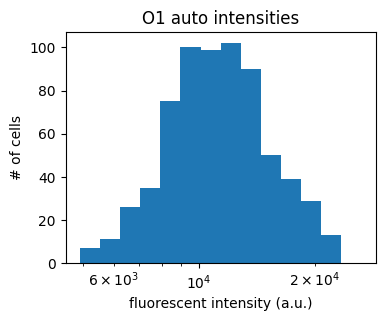

In [ ]:
# create a histogram for all of the files for operator 1 and auto repressor
O1auto = strain_totals("O1", "auto")
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')
ax.set_title("O1 auto intensities")
ax.set_xscale("log")

ax.hist(O1auto, bins=np.logspace(np.log10(min(O1auto)), np.log10(max(O1auto)), 15));

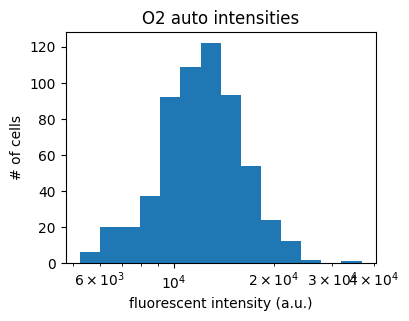

In [ ]:
# create a histogram for all of the files for operator 2 and auto repressor
O2auto = strain_totals("O2", "auto")
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')
ax.set_title("O2 auto intensities")
ax.set_xscale("log")

ax.hist(O2auto, bins=np.logspace(np.log10(min(O2auto)), np.log10(max(O2auto)), 15));

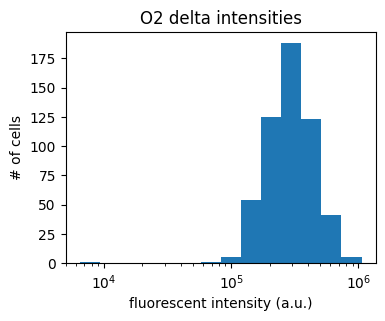

In [ ]:
# create a histogram for all of the files for operator 2 and delta repressor
O2delta = strain_totals("O2", "delta")
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')
ax.set_title("O2 delta intensities")
ax.set_xscale("log")

ax.hist(O2delta, bins=np.logspace(np.log10(min(O2delta)), np.log10(max(O2delta)), 15));

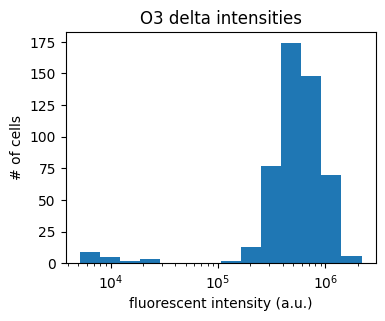

In [ ]:
# create a histogram for all of the files for operator 3 and delta repressor
O3delta = strain_totals("O3", "delta")
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlabel('fluorescent intensity (a.u.)')
ax.set_ylabel('# of cells')
ax.set_title("O3 delta intensities")
ax.set_xscale("log")

ax.hist(O3delta, bins=np.logspace(np.log10(min(O3delta)), np.log10(max(O3delta)), 15));

## Question 1f

In [ ]:
# Arrays of the operators to be processed and the repressor names
ops = ['O1', 'O2', 'O3']
rep_names = ['R22', 'R60', 'R124', 'R260']
rep_nums = [22, 60, 124, 260]

foldchanges = []
# loop through each of the operators
for i in range(len(ops)):
  # create a 2d array to organize the foldchanges for each operator
  foldchanges.append([])
  # generate the intensities for the auto repressor
  auto = strain_totals(ops[i], "auto")
  # compute the average intensity for the auto repressor
  automean = np.mean(auto)
  # generate the intensities for the delta repressor
  delta = strain_totals(ops[i], "delta")
  # compute the average intensity for the delta repressor
  deltamean = np.mean(delta)

  # loop through each of the repressors
  for j in range(len(rep_nums)):
    # generator the intensity for the number of repressors for some operator
    repressor = strain_totals(ops[i], rep_names[j])
    # compute the average intensity for the non zero repressor
    repressormean = np.mean(repressor)

    # computes the foldchange based on the formula and appends it to the 2d
    # array for the fold changes
    foldchange = (repressormean - automean)/(deltamean - automean)
    foldchanges[i].append(foldchange)

print(foldchanges)


[[0.02102420034421455, 0.019090847506677954, 0.0097609039479723, 0.005576862061222264], [0.14532349300531136, 0.042168737404817386, 0.0148684975014766, 0.009731365554625148], [0.8991302806952141, 0.7466111254074383, 0.9693887451176495, 0.7367561773749588]]


## Question 1g

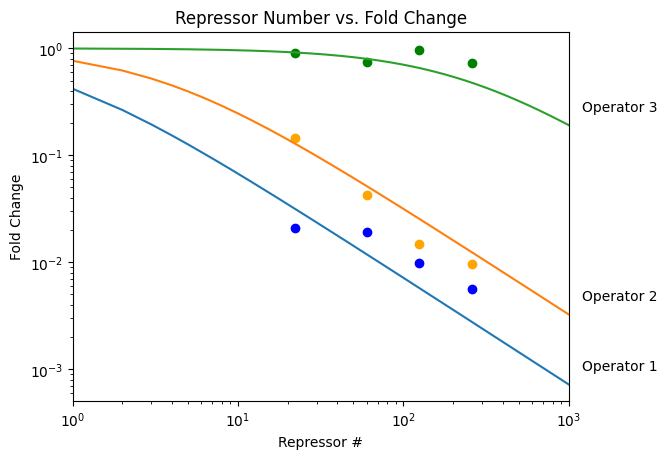

In [ ]:
r = []
fc1 = []
fc2 = []
fc3 = []

# loop to 1000 for the repressor #
for i in range(1000):
  # generates the x-axis
  r.append(i)
  # use the equations defined in 1B to plot the fold change curves for each
  # operator as repressor number ranges to 1000
  fc1.append(foldchange1(i))
  fc2.append(foldchange2(i))
  fc3.append(foldchange3(i))

# plot all three graphs
plt.plot(r, fc1)
plt.plot(r, fc2)
plt.plot(r, fc3)
plt.xlabel("Repressor #")
plt.ylabel("Fold Change")
plt.title("Repressor Number vs. Fold Change")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 1000)

# label each curve
plt.annotate('Operator 1', xy=(r[-1], fc1[-1]), xytext=(10, 10), textcoords='offset points')
plt.annotate('Operator 2', xy=(r[-1], fc2[-1]), xytext=(10, 10), textcoords='offset points')
plt.annotate('Operator 3', xy=(r[-1], fc3[-1]), xytext=(10, 10), textcoords='offset points')

# plot all the calculated points from the microscopy data
plt.scatter(22, 0.02102420034421455, color='blue')
plt.scatter(60, 0.019090847506677954, color='blue')
plt.scatter(124, 0.0097609039479723, color='blue')
plt.scatter(260, 0.005576862061222264, color='blue')

plt.scatter(22, 0.14532349300531136, color='orange')
plt.scatter(60, 0.042168737404817386, color='orange')
plt.scatter(124, 0.0148684975014766, color='orange')
plt.scatter(260, 0.009731365554625148, color='orange')

plt.scatter(22, 0.8991302806952141, color='green')
plt.scatter(60, 0.7466111254074383, color='green')
plt.scatter(124, 0.9693887451176495, color='green')
plt.scatter(260, 0.7367561773749588, color='green')

Some data points are outliers. This can be explained by experimental and computational reasons. The fold change was calculated using data that described the fluorescent intensity of images. Experimentally, when the images were taken, there could have been background light that impacted the accuracy of the data. Additionally, we did not calculate the intensity for clusters of cells. So, computationally, we have fewer data points which can account for the discrepancy.



## Question 1h

In [ ]:
# process the csv dataset for the lacZ data
lacZ_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bi1/lacZ_titration_data.csv', header=8)

# store the data for each operator in a separate variable
O1_df = lacZ_df[lacZ_df['operator']=='O1']
O2_df = lacZ_df[lacZ_df['operator']=='O2']
O3_df = lacZ_df[lacZ_df['operator']=='O3']

print(O1_df)
print(O2_df)
print(O3_df)

    repressor  fold_change operator
8       22.42     0.038860       O1
9       59.34     0.008902       O1
10     124.00     0.004721       O1
11     225.30     0.002774       O1
   repressor  fold_change operator
4      22.42      0.17560       O2
5      59.34      0.04519       O2
6     124.00      0.02151       O2
7     255.30      0.01241       O2
   repressor  fold_change operator
0      22.42       0.7985       O3
1      59.34       0.6524       O3
2     124.00       0.6210       O3
3     255.30       0.4773       O3


In [ ]:
NNS=4.6e6
# formula for the log of the fold change.
def log_convention_fold_change_theory(R, epsilon_r):
  return np.log(1/(1+ R/NNS * np.exp(-epsilon_r)))

In [ ]:
# all the operators in the csv file to access them easier
operatornames = [O1_df, O2_df, O3_df]

# loop through each operator
for i in range(3):
  repressorvals = []
  # extract the repressor data and add them to an array
  repressorvals.extend(operatornames[i]['repressor'].tolist())

  fcvals = []
  # extract the fold change data and add them to an array
  fcvals.extend(operatornames[i]['fold_change'].tolist())

  # least square fitting on the log equation of the fold change
  popt, pcov = scipy.optimize.curve_fit(log_convention_fold_change_theory, repressorvals, np.log(fcvals))
  print(popt)

[-15.77672204]
[-14.17011337]
[-10.04600127]


Compared to only fitting with one point, the binding energies computed using the least-squares techniques are roughly the same as compared to a single data point. Operator 1 for the least square was -15.77672204 whereas the single data point was -15.667019347. They are off by about 0.1. For operator 2, the binding energies are also about the same. Using least square fitting, operator two's value is about -14.17011337 and using one data point, the value is about -14.158466515. These two values are even closer in magnitude. However, operator 3 differed the most. The least square fitting was -10.046 and the single data point was -9.87295.

## Question 1i

In [ ]:
# array of all the repressor numbers for the microscopy data
repressorvalsi = [22, 60, 124, 260]
# loop through each operator
for i in range(3):
  foldchangevals = []
  # loop through each repressor
  for j in range(4):
    # add the foldchanges to one array
    foldchangevals.append(foldchanges[i][j])
  # least square fitting on the log equation of the fold change with the microscopy data
  popt, pcov = scipy.optimize.curve_fit(log_convention_fold_change_theory, repressorvalsi, np.log(foldchangevals))
  print(popt)

[-15.33474789]
[-14.39532018]
[-8.75261549]


Using the lacZ measurements, the values for operators 1 and 2 are still very similar to the predicted values. The lacZ measurement for operator 1 is -15.33474789 and the single data point is -15.6670193. These values are pretty close to each other and differ by only 0.3. As for operator 2, the lacZ data gives about -14.39532 while the single data point gives about -14.1584665. These are also close and only differ by 0.2. However, like the microscopy data, operator 3 has the biggest discrepancy. The lacZ data is -8.75261549 while the single data point is -9.87295. Both the lacZ and the microscopy datasets had the biggest discrepancy for operator 3. Taking into context that the data for operator 1 and 2 are very close to the predicted value, the datasets for operator 3 may not be the most accurate and have significant error. There are many sources of experimental error when collecting the data for operator 3. This could explain the discrepancies.

## Question 1j

In [ ]:
# create functions to calculate the fold change for the binding energy found for
# each operator using the microscopy data.
def foldchange1jm(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 15.335)))

def foldchange2jm(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 14.395)))

def foldchange3jm(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 8.753)))

In [ ]:
# create functions to calculate the fold change for the binding energy found for
# each operator using the lacZ data.
def foldchange1jl(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 15.777)))

def foldchange2jl(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 14.17)))

def foldchange3jl(repressor):
  return 1/(1+((repressor/(4.6 * pow(10,6)))*pow(np.e, 10.046)))

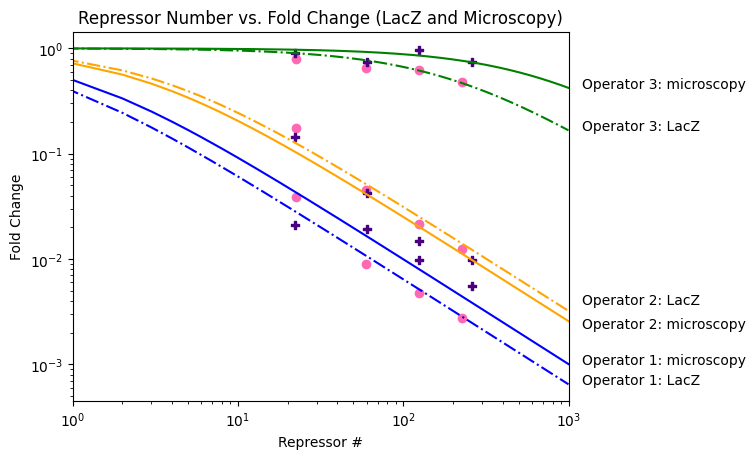

In [ ]:
rj = []
fc1jm = []
fc2jm = []
fc3jm = []
fc1jl = []
fc2jl = []
fc3jl = []

# loop through all the repressor numbers up to 1000 to calculate the fold changes
# for each operator and for each data set using the previously defined functions
# that use the binding energy
for i in range(1000):
  rj.append(i)
  fc1jm.append(foldchange1jm(i))
  fc2jm.append(foldchange2jm(i))
  fc3jm.append(foldchange3jm(i))
  fc1jl.append(foldchange1jl(i))
  fc2jl.append(foldchange2jl(i))
  fc3jl.append(foldchange3jl(i))

# plot all of the functions of the fold change
plt.plot(rj, fc1jm, "blue")
plt.plot(rj, fc2jm, "orange")
plt.plot(rj, fc3jm, "green")
plt.plot(rj, fc1jl, "blue", linestyle = "dashdot")
plt.plot(rj, fc2jl, "orange", linestyle = "dashdot")
plt.plot(rj, fc3jl, "green", linestyle = "dashdot")
plt.xlabel("Repressor #")
plt.ylabel("Fold Change")
plt.title("Repressor Number vs. Fold Change (LacZ and Microscopy)")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 1000)

# label all of the graphs to show which operator and dataset it represents
plt.annotate('Operator 1: microscopy', xy=(rj[-1], fc1jm[-1]), xytext=(10, 0), textcoords='offset points')
plt.annotate('Operator 2: microscopy', xy=(rj[-1], fc2jm[-1]), xytext=(10, -5), textcoords='offset points')
plt.annotate('Operator 3: microscopy', xy=(rj[-1], fc3jm[-1]), xytext=(10, 0), textcoords='offset points')
plt.annotate('Operator 1: LacZ', xy=(rj[-1], fc1jl[-1]), xytext=(10, 0), textcoords='offset points')
plt.annotate('Operator 2: LacZ', xy=(rj[-1], fc2jl[-1]), xytext=(10, 5), textcoords='offset points')
plt.annotate('Operator 3: LacZ', xy=(rj[-1], fc3jl[-1]), xytext=(10, 0), textcoords='offset points')

# plot all the points from the lacZ dataset for each operator
plt.scatter(22.42, 0.038860, color='hotpink')
plt.scatter(59.34, 0.008902, color='hotpink')
plt.scatter(124, 0.004721, color='hotpink')
plt.scatter(225.30, 0.002774, color='hotpink')

plt.scatter(22.42, 0.17560, color='hotpink')
plt.scatter(59.34, 0.04519, color='hotpink')
plt.scatter(124, 0.02151, color='hotpink')
plt.scatter(225.30, 0.01241, color='hotpink')

plt.scatter(22.42, 0.7985, color='hotpink')
plt.scatter(59.34, 0.6524, color='hotpink')
plt.scatter(124, 0.6210, color='hotpink')
plt.scatter(225.30, 0.4773, color='hotpink')

# plot all the points for the microscopy calculated values for each operator
plt.scatter(22, 0.02102420034421455, color='indigo', marker = "P")
plt.scatter(60, 0.019090847506677954, color='indigo', marker = "P")
plt.scatter(124, 0.0097609039479723, color='indigo', marker = "P")
plt.scatter(260, 0.005576862061222264, color='indigo', marker = "P")

plt.scatter(22, 0.14532349300531136, color='indigo', marker = "P")
plt.scatter(60, 0.042168737404817386, color='indigo', marker = "P")
plt.scatter(124, 0.0148684975014766, color='indigo', marker = "P")
plt.scatter(260, 0.009731365554625148, color='indigo', marker = "P")

plt.scatter(22, 0.8991302806952141, color='indigo', marker = "P")
plt.scatter(60, 0.7466111254074383, color='indigo', marker = "P")
plt.scatter(124, 0.9693887451176495, color='indigo', marker = "P")
plt.scatter(260, 0.7367561773749588, color='indigo', marker = "P")

For the most part, both graphs agree. They all follow the same trajectory. The only discrepancy is in operator 3 where the two curves have a little significant gap between them. This is explained by the discrepancy explained in parts 1h and 1i. There is some non-negligible error in the data for operator 3. While they still roughly follow the same path, this does not indicate a fault in theory but rather some fault in the measurements. The faulty measurements is also supported by the data analysis in parts 1h and 1i. Both operators 1 and 2 are more close together for each dataset, LacZ and Microscopy, demonstrating how the theory is not inaccurate.

---

### Submission instructions

When you're finished, recall the steps for submitting Colab notebooks:

1. Run all the cells from top-to-bottom, in order (`Runtime` > `Run all`).
2. Once the entire notebook has completed running and the output of all cells is visible, save it (`File` > `Save`).
3. Download the notebook in `.ipynb` format (`File` > `Download` > `Download .ipynb`).
4. Rename the file according to the usual convention (`lastname_firstname_hw#.ipynb`), if you haven't already.
5. Upload the file to Gradescope.
